# Importando e tratando os dados

In [1]:
!pip install numpy pandas seaborn matplotlib statsmodels statsforecast scikit-learn prophet xgboost


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

# ferramentas de análise exploratória
from statsforecast import StatsForecast
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from scipy import stats

# métricas
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score

# modelos
from statsmodels.tsa.arima.model import ARIMA
from statsforecast.models import AutoARIMA
from prophet import Prophet
from prophet.plot import plot_plotly as prophet_plot
import xgboost as xgb


In [3]:
# Carregando os dados do arquivo CSV
df = pd.read_csv('dados_ibovespa.csv', sep=',', thousands='.', parse_dates=[0], date_format='%d.%m.%Y')
df.head()

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
0,2024-07-22,127860,127616,128151,127456,"6,10B","0,19%"
1,2024-07-19,127616,127652,128360,127413,"7,62B","-0,03%"
2,2024-07-18,127652,129450,129454,127523,"7,59B","-1,39%"
3,2024-07-17,129450,129112,129658,128741,"6,67B","0,26%"
4,2024-07-16,129110,129322,129521,128761,"6,82B","-0,16%"


In [4]:
# Filtrando os dados
data_inicio = pd.to_datetime('2021-07-22')  # Data a partir da qual queremos as previsões

df = df[df['Data'] >= data_inicio]
df.head()

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
0,2024-07-22,127860,127616,128151,127456,"6,10B","0,19%"
1,2024-07-19,127616,127652,128360,127413,"7,62B","-0,03%"
2,2024-07-18,127652,129450,129454,127523,"7,59B","-1,39%"
3,2024-07-17,129450,129112,129658,128741,"6,67B","0,26%"
4,2024-07-16,129110,129322,129521,128761,"6,82B","-0,16%"


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 749 entries, 0 to 748
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Data      749 non-null    datetime64[ns]
 1   Último    749 non-null    int64         
 2   Abertura  749 non-null    int64         
 3   Máxima    749 non-null    int64         
 4   Mínima    749 non-null    int64         
 5   Vol.      749 non-null    object        
 6   Var%      749 non-null    object        
dtypes: datetime64[ns](1), int64(4), object(2)
memory usage: 46.8+ KB


In [6]:
# Lista de nomes das colunas desejados
nomes_colunas = ['data', 'fechamento','abertura', 'maxima', 'minima', 'volume', 'variacao']

# Renomeando as colunas
df.columns = nomes_colunas
df.head()

,data,fechamento,abertura,maxima,minima,volume,variacao
0,2024-07-22,127860,127616,128151,127456,"6,10B","0,19%"
1,2024-07-19,127616,127652,128360,127413,"7,62B","-0,03%"
2,2024-07-18,127652,129450,129454,127523,"7,59B","-1,39%"
3,2024-07-17,129450,129112,129658,128741,"6,67B","0,26%"
4,2024-07-16,129110,129322,129521,128761,"6,82B","-0,16%"


In [7]:
# Tratando volume - removendo letras e substituir vírgula por ponto
df['volume'] = df['volume'].str.replace('B', 'e9').str.replace('M', 'e6').str.replace('K','e3').str.replace(',', '.')

# Convertendo para numérico
df['volume'] = pd.to_numeric(df['volume'])

df.head()

,data,fechamento,abertura,maxima,minima,volume,variacao
0,2024-07-22,127860,127616,128151,127456,6.100000e+09,"0,19%"
1,2024-07-19,127616,127652,128360,127413,7.620000e+09,"-0,03%"
2,2024-07-18,127652,129450,129454,127523,7.590000e+09,"-1,39%"
3,2024-07-17,129450,129112,129658,128741,6.670000e+09,"0,26%"
4,2024-07-16,129110,129322,129521,128761,6.820000e+09,"-0,16%"


In [8]:
# Tratando variação - Removendo o símbolo de porcentagem e converter para float
df['variacao'] = df['variacao'].str.replace('%', '').str.replace(',', '.').astype(float)

df.head()

,data,fechamento,abertura,maxima,minima,volume,variacao
0,2024-07-22,127860,127616,128151,127456,6.100000e+09,0.19
1,2024-07-19,127616,127652,128360,127413,7.620000e+09,-0.03
2,2024-07-18,127652,129450,129454,127523,7.590000e+09,-1.39
3,2024-07-17,129450,129112,129658,128741,6.670000e+09,0.26
4,2024-07-16,129110,129322,129521,128761,6.820000e+09,-0.16


In [9]:
# Ordenando os dados pela data em ordem crescrente
df = df.sort_values('data').reset_index(drop=True)
df.head()

,data,fechamento,abertura,maxima,minima,volume,variacao
0,2021-07-22,126147,125930,126428,125416,6480000.0,0.17
1,2021-07-23,125053,126140,126204,124422,6050000.0,-0.87
2,2021-07-26,126004,125058,126214,125006,6330000.0,0.76
3,2021-07-27,124612,126004,126026,123670,7310000.0,-1.10
4,2021-07-28,126286,124615,126712,124542,9040000.0,1.34


In [10]:
df.tail()

,data,fechamento,abertura,maxima,minima,volume,variacao
744,2024-07-16,129110,129322,129521,128761,6.820000e+09,-0.16
745,2024-07-17,129450,129112,129658,128741,6.670000e+09,0.26
746,2024-07-18,127652,129450,129454,127523,7.590000e+09,-1.39
747,2024-07-19,127616,127652,128360,127413,7.620000e+09,-0.03
748,2024-07-22,127860,127616,128151,127456,6.100000e+09,0.19


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 749 entries, 0 to 748
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   data        749 non-null    datetime64[ns]
 1   fechamento  749 non-null    int64         
 2   abertura    749 non-null    int64         
 3   maxima      749 non-null    int64         
 4   minima      749 non-null    int64         
 5   volume      749 non-null    float64       
 6   variacao    749 non-null    float64       
dtypes: datetime64[ns](1), float64(2), int64(4)
memory usage: 41.1 KB


In [12]:
# convertendo data em índice
df = df.set_index('data')

df.head()

,fechamento,abertura,maxima,minima,volume,variacao
data,,,,,,
2021-07-22,126147,125930,126428,125416,6480000.0,0.17
2021-07-23,125053,126140,126204,124422,6050000.0,-0.87
2021-07-26,126004,125058,126214,125006,6330000.0,0.76
2021-07-27,124612,126004,126026,123670,7310000.0,-1.10
2021-07-28,126286,124615,126712,124542,9040000.0,1.34


# Análise Exploratória dos Dados

## Passo 1: Visualização dos dados

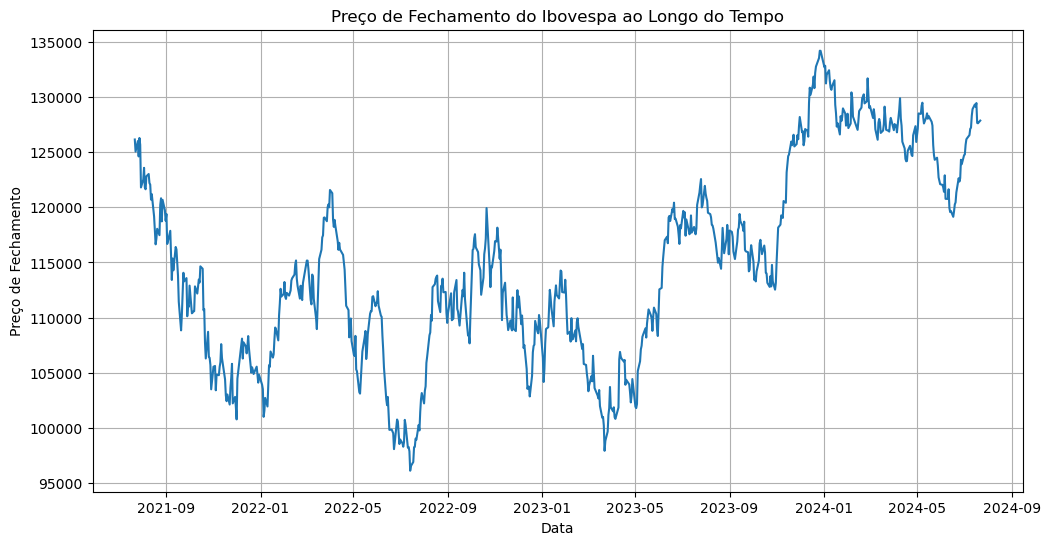

In [13]:
# Gráfico de linha do preço de fechamento ao longo do tempo

plt.figure(figsize=(12, 6))
plt.plot(df.index, df['fechamento'], linestyle='-')
plt.title('Preço de Fechamento do Ibovespa ao Longo do Tempo')
plt.xlabel('Data')
plt.ylabel('Preço de Fechamento')
plt.grid(True)
plt.show()

### Visualização das estatísticas rolantes

In [14]:
# Estatísticas rolantes
rolmean = df['fechamento'].rolling(window=12).mean()
rolstd = df['fechamento'].rolling(window=12).std()

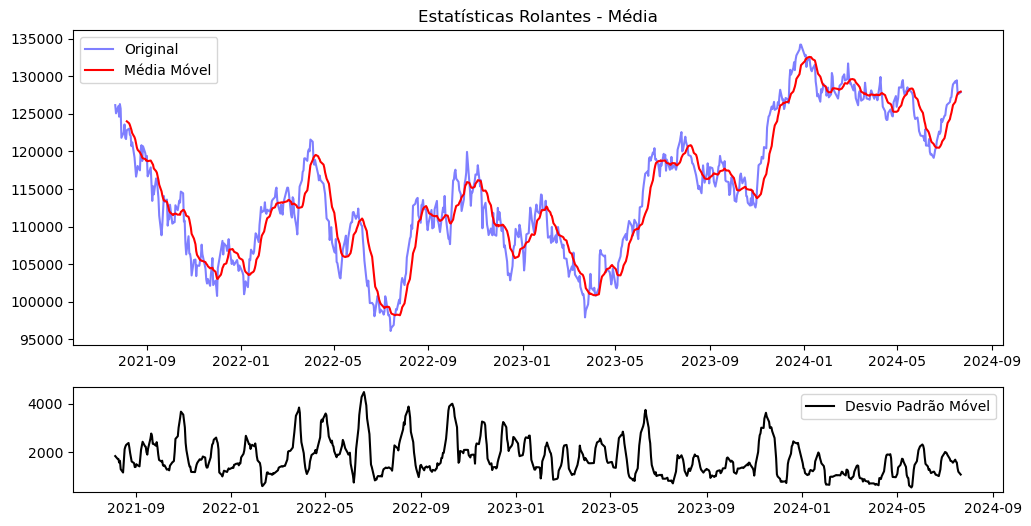

In [15]:
# Plot das estatísticas rolantes
fig = plt.figure(figsize=(12, 6))

gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])

ax1 = fig.add_subplot(gs[0])
ax1.plot(df['fechamento'], color='blue', label='Original', alpha=0.5)
ax1.plot(rolmean, color='red', label='Média Móvel')
ax1.legend(loc='best')
ax1.set_title('Estatísticas Rolantes - Média')

ax2 = fig.add_subplot(gs[1])
ax2.plot(rolstd, color='black', label='Desvio Padrão Móvel')
ax2.legend(loc='best')

plt.show()

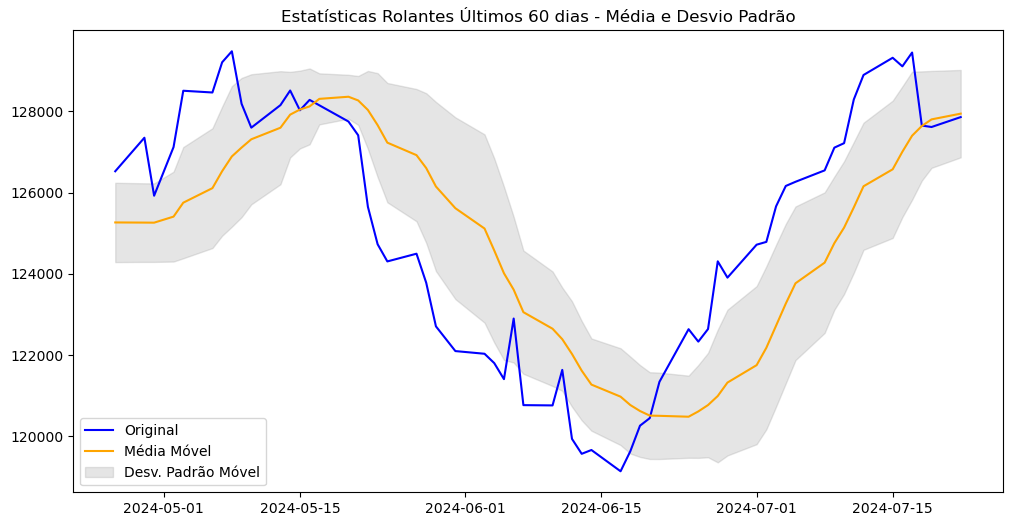

In [16]:
# Estatísticas Rolantes Últimos 60 dias

df_recent = df['fechamento'][-60:]
rolmean_recent = rolmean[-60:]
rolstd_recent = rolstd[-60:]

# Plot das estatísticas rolantes últimos 60 dias
plt.figure(figsize=(12, 6))
plt.plot(df_recent, color='blue', label='Original')
plt.plot(rolmean_recent, color='orange', label='Média Móvel')
plt.fill_between(df_recent.index, (rolmean_recent - rolstd_recent), (rolmean_recent + rolstd_recent), color='gray', alpha=0.2, label='Desv. Padrão Móvel')

plt.legend(loc='best')
plt.title('Estatísticas Rolantes Últimos 60 dias - Média e Desvio Padrão')
plt.show()

### Decomposição da Série Temporal

In [17]:
resultados = seasonal_decompose(df['fechamento'], model='additive', period=30)  # Exemplo de período sazonal de 30 dias

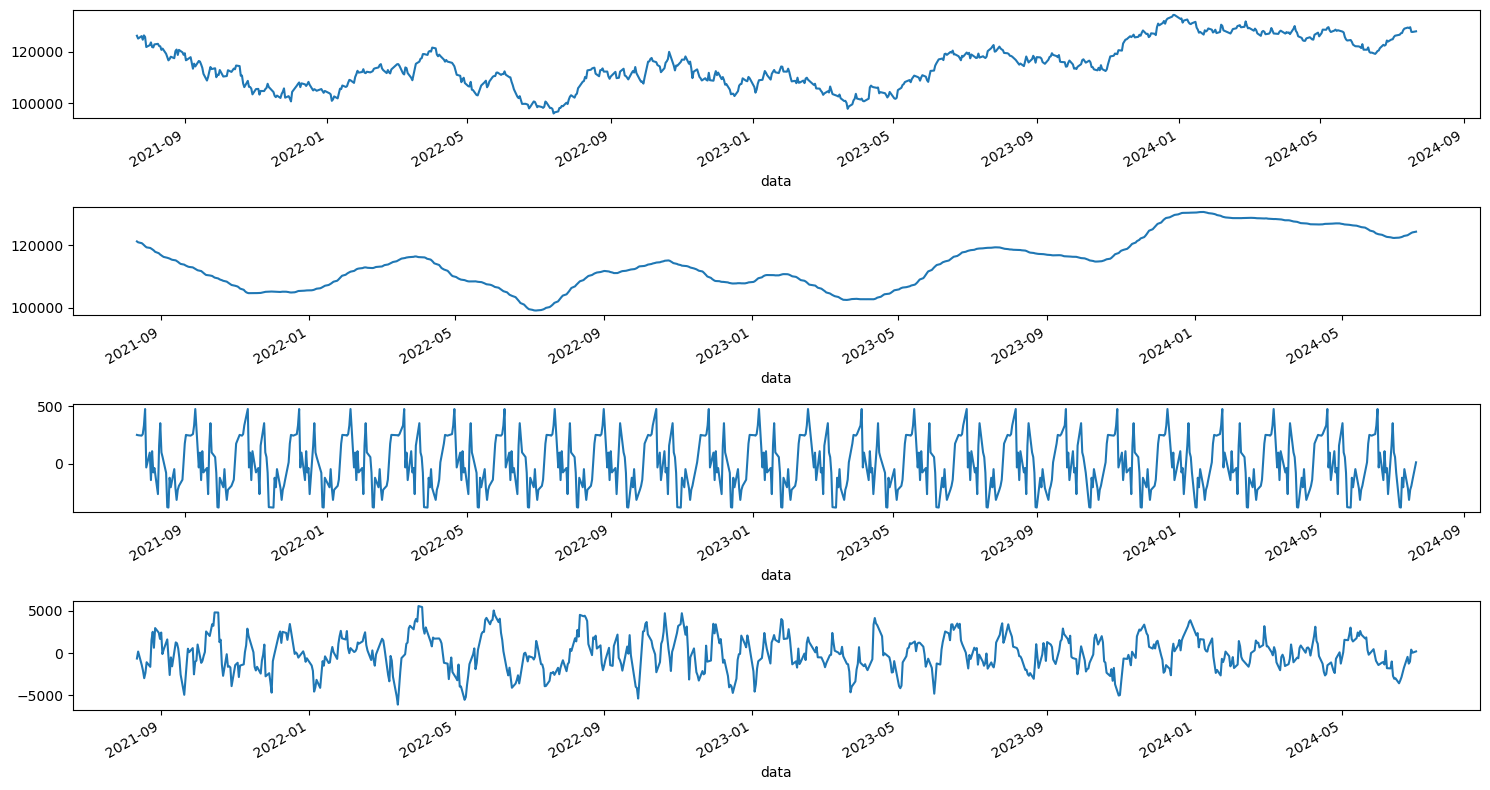

In [18]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15,8))

resultados.observed.plot(ax = ax1)

#tendencia
resultados.trend.plot(ax = ax2)

#sazonalidade
resultados.seasonal.plot(ax = ax3)

#residuo dos dados
resultados.resid.plot(ax = ax4)

plt.tight_layout()

## Passo 2: Testes de estacionariedade e sazonalidade

### Teste de Estacionariedade

In [19]:
# Teste de Dickey-Fuller
print('Resultados do Teste de Dickey-Fuller:')
dftest = adfuller(df['fechamento'], autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Estatística do Teste', 'Valor-p', 'Número de Lags Usados', 'Número de Observações Usadas'])
for key, value in dftest[4].items():
    dfoutput['Valor Crítico (%s)' % key] = value
print(dfoutput)

# Verificar o valor-p e imprimir o resultado do teste de estacionariedade
if dftest[1] > 0.05:
    print("H0 - HIPOTESE NULA (NÃO É ESTACIONÁRIA)")
else:
    print("H1 - HIPOTESE ALTERNATIVA (REJEIÇÃO DA HIPOTESE NULA, OU SEJA, É ESTACIONÁRIA)")

Resultados do Teste de Dickey-Fuller:
Estatística do Teste             -1.972615
Valor-p                           0.298708
Número de Lags Usados             0.000000
Número de Observações Usadas    748.000000
Valor Crítico (1%)               -3.439123
Valor Crítico (5%)               -2.865412
Valor Crítico (10%)              -2.568832
dtype: float64
H0 - HIPOTESE NULA (NÃO É ESTACIONÁRIA)


### Teste de Sazonalidade

In [20]:
#TESTE DE SAZONALIDADE

# Separar os dados por períodos sazonais
groups = [group[1]['fechamento'].values for group in df.groupby(df.index.month)]

# Aplicar o teste de Fisher
statistic, p= stats.f_oneway(*groups)

# Imprimir o valor-p
print(f'Valor-p do teste de Fisher: {p:.4f}')

if p > 0.05:
  print("Não há evidencia suficiente para rejeitar a hipotese de sazonalidade")
else:
  print("A hipotese de sazonalidade é rejeitada")

Valor-p do teste de Fisher: 0.3094
Não há evidencia suficiente para rejeitar a hipotese de sazonalidade


### Análise dos Resultados

- Estatística do Teste (ADF): -1.222467

A estatística do teste de Dickey-Fuller é significativamente maior que os valores críticos em todos os níveis de significância (1%, 5%, 10%). Isso indica que não temos evidências estatísticas suficientes para rejeitar a hipótese nula de que a série possui uma raiz unitária, ou seja, podemos considerar a série como não estacionária, ou seja, apresenta tendências claras, sazonalidades ou variações que dependam do tempo.

- Valor-p: 0.68

O valor-p é não é pequeno (0.68), ou seja, 68% significativamente maior que qualquer nível de significância comum, algo em torno de 5% (0.05). Isso reforça ainda mais a conclusão de que a série não é estacionária.

#### Conclusão

Com base nos resultados do teste, podemos concluir que a série temporal do preço de fechamento do Ibovespa não é estacionária. A estatística do teste de ADF é maior que os valores críticos correspondentes e o valor-p alto, comparado com o nivel de signficancia comum (5%), indicando que há raiz unitária na série e que ela não é estacionária.

Portanto, podemos **proceder com confiança para modelagem e previsão usando métodos adequados para séries temporais como ARIMA** por exemplo.

# Predição

## Passo 1: Preparação dos Dados e Modelagem

In [21]:
df_modelagem = df[['fechamento', 'abertura']]
df_modelagem.tail()

,fechamento,abertura
data,,
2024-07-16,129110,129322
2024-07-17,129450,129112
2024-07-18,127652,129450
2024-07-19,127616,127652
2024-07-22,127860,127616


In [22]:
df_modelagem.shape

(749, 2)

In [23]:
## Dividindo dados em treino e teste

test_size = 90
tamanho_treino = df_modelagem.shape[0] - test_size
treino = df_modelagem[:tamanho_treino]
teste = df_modelagem[tamanho_treino:]

In [24]:
treino.tail()

,fechamento,abertura
data,,
2024-03-07,128340,128890
2024-03-08,127071,128335
2024-03-11,126124,127068
2024-03-12,127668,126124
2024-03-13,128006,127668


In [25]:
teste.head()

,fechamento,abertura
data,,
2024-03-14,127690,127992
2024-03-15,126742,127682
2024-03-18,126954,126758
2024-03-19,127529,126955
2024-03-20,129125,127534


In [26]:
treino.shape

(659, 2)

In [27]:
teste.shape

(90, 2)

## Passo 2: Métricas de avaliação dos modelos

In [28]:
# Funções de Avaliação
def calculate_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    return mae, mse, mape


def print_metrics(model, metrics):
    mae, mse, mape = metrics
    print(f'{model} Metrics:')
    print(f"MAE: {mae}")
    print(f"MSE: {mse}")
    print(f"MAPE: {mape}")

## Passo 2: Treinando e avaliando modelos

### ARIMA

In [29]:
# Preparando dados de treino para ARIMA
treino_arima = treino[['fechamento']]
treino_arima.tail()

,fechamento
data,
2024-03-07,128340
2024-03-08,127071
2024-03-11,126124
2024-03-12,127668
2024-03-13,128006


In [30]:
# Preparando dados de teste para ARIMA
teste_arima = teste[['fechamento']]
teste_arima.tail()

,fechamento
data,
2024-07-16,129110
2024-07-17,129450
2024-07-18,127652
2024-07-19,127616
2024-07-22,127860


In [31]:
# Ajustando o modelo ARIMA
modelo_arima = ARIMA(treino_arima, order=(5, 1, 0))
modelo_arima_fit = modelo_arima.fit()

/home/alexandre/miniconda3/envs/pydata-book/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/alexandre/miniconda3/envs/pydata-book/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/alexandre/miniconda3/envs/pydata-book/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [32]:
# Fazendo previsões
previsoes_arima = modelo_arima_fit.predict(start=len(treino_arima), end=len(treino_arima) + len(teste_arima) - 1, typ='levels')

/home/alexandre/miniconda3/envs/pydata-book/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/alexandre/miniconda3/envs/pydata-book/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/home/alexandre/miniconda3/envs/pydata-book/lib/python3.10/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


In [33]:
previsoes_arima.tail()

744    128009.84229
745    128009.84229
746    128009.84229
747    128009.84229
748    128009.84229
Name: predicted_mean, dtype: float64

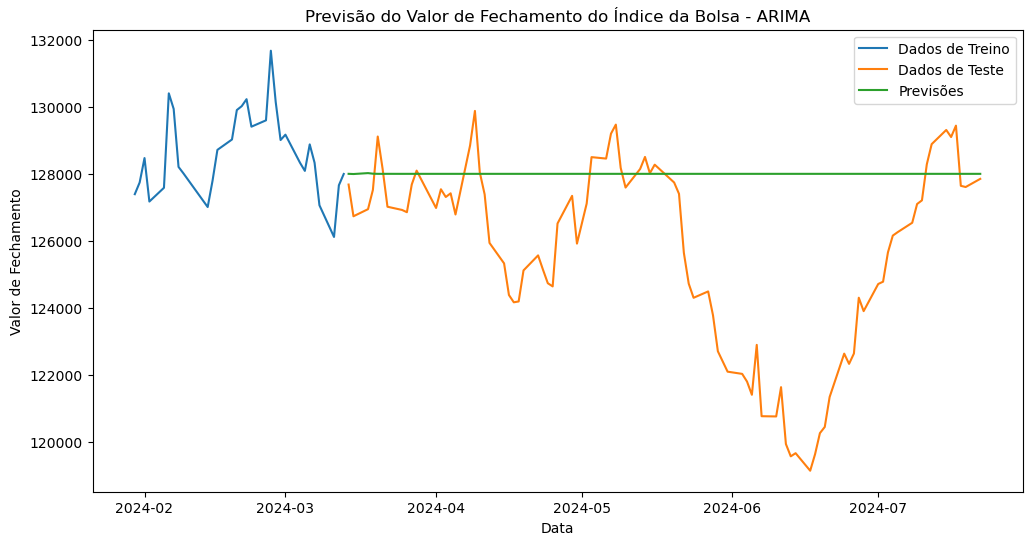

In [34]:
# Visualizando as previsões do modelo ARIMA
plt.figure(figsize=(12, 6))
plt.plot(treino_arima[-30:], label='Dados de Treino')
plt.plot(teste_arima.index, teste_arima, label='Dados de Teste')
plt.plot(teste_arima.index, previsoes_arima, label='Previsões')
plt.title('Previsão do Valor de Fechamento do Índice da Bolsa - ARIMA')
plt.xlabel('Data')
plt.ylabel('Valor de Fechamento')
plt.legend()
plt.show()

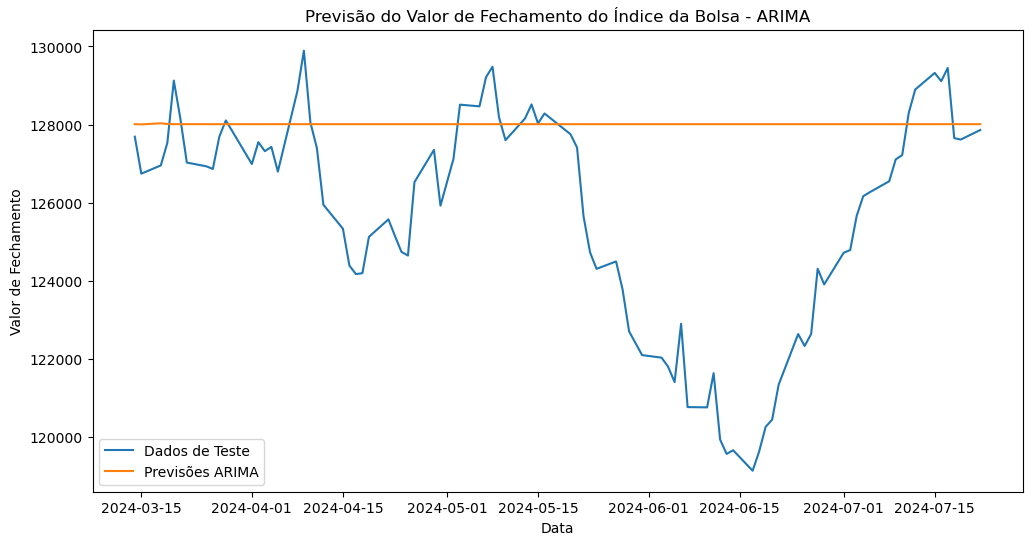

In [35]:
# Visualizando as previsões do modelo ARIMA
plt.figure(figsize=(12, 6))
plt.plot(teste_arima.index, teste_arima, label='Dados de Teste')
plt.plot(teste_arima.index, previsoes_arima, label='Previsões ARIMA')
plt.title('Previsão do Valor de Fechamento do Índice da Bolsa - ARIMA')
plt.xlabel('Data')
plt.ylabel('Valor de Fechamento')
plt.legend()
plt.show()

In [36]:
metrics_arima = calculate_metrics(teste_arima.values, previsoes_arima)
print_metrics('ARIMA', metrics_arima)

ARIMA Metrics:
MAE: 2671.2412734043564
MSE: 13560122.027282476
MAPE: 2.171681891039403


### AutoARIMA

In [37]:
# Preparando dados de treino para AutoARIMA
treino_autoarima = treino.copy()
treino_autoarima = treino_autoarima.reset_index()
treino_autoarima = treino_autoarima.rename(columns={"data": "ds", "fechamento": "y"})
treino_autoarima['unique_id'] = 'Bolsa de Valores'
treino_autoarima.tail()

,ds,y,abertura,unique_id
654,2024-03-07,128340,128890,Bolsa de Valores
655,2024-03-08,127071,128335,Bolsa de Valores
656,2024-03-11,126124,127068,Bolsa de Valores
657,2024-03-12,127668,126124,Bolsa de Valores
658,2024-03-13,128006,127668,Bolsa de Valores


In [38]:
# Preparando dados de teste para AutoARIMA
teste_autoarima = teste.copy()
teste_autoarima = teste_autoarima.reset_index()
teste_autoarima = teste_autoarima.rename(columns={"data": "ds", "fechamento": "y"})
teste_autoarima['unique_id'] = 'Bolsa de Valores'
teste_autoarima.head()

,ds,y,abertura,unique_id
0,2024-03-14,127690,127992,Bolsa de Valores
1,2024-03-15,126742,127682,Bolsa de Valores
2,2024-03-18,126954,126758,Bolsa de Valores
3,2024-03-19,127529,126955,Bolsa de Valores
4,2024-03-20,129125,127534,Bolsa de Valores


In [39]:
X_df_autorima = teste_autoarima[['ds', 'abertura', 'unique_id']]
X_df_autorima.head()

,ds,abertura,unique_id
0,2024-03-14,127992,Bolsa de Valores
1,2024-03-15,127682,Bolsa de Valores
2,2024-03-18,126758,Bolsa de Valores
3,2024-03-19,126955,Bolsa de Valores
4,2024-03-20,127534,Bolsa de Valores


In [40]:
modelo_autoarima = StatsForecast(models=[AutoARIMA(season_length=1)], freq='B',n_jobs=-1) # season_length=1 (sem sazonalidade) freq='B' (dias úteis - business days)
modelo_autoarima.fit(treino_autoarima)
previsoes_autoarima = modelo_autoarima.predict(h=test_size, level = [90], X_df = X_df_autorima) # h=test_size, level=[90] (nível de confiança)
previsoes_autoarima.tail()

/home/alexandre/miniconda3/envs/pydata-book/lib/python3.10/site-packages/statsforecast/core.py:492: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


,ds,AutoARIMA,AutoARIMA-lo-90,AutoARIMA-hi-90
unique_id,,,,
Bolsa de Valores,2024-07-11,128025.265625,107232.640625,148817.875000
Bolsa de Valores,2024-07-12,128022.820312,107109.656250,148935.968750
Bolsa de Valores,2024-07-15,128026.750000,106993.750000,149059.750000
Bolsa de Valores,2024-07-16,128005.812500,106853.640625,149157.984375
Bolsa de Valores,2024-07-17,128005.390625,106734.718750,149276.062500


/home/alexandre/miniconda3/envs/pydata-book/lib/python3.10/site-packages/statsforecast/core.py:1447: FutureWarning: Passing the ids as the index is deprecated. Please provide them as a column instead.
  warnings.warn(


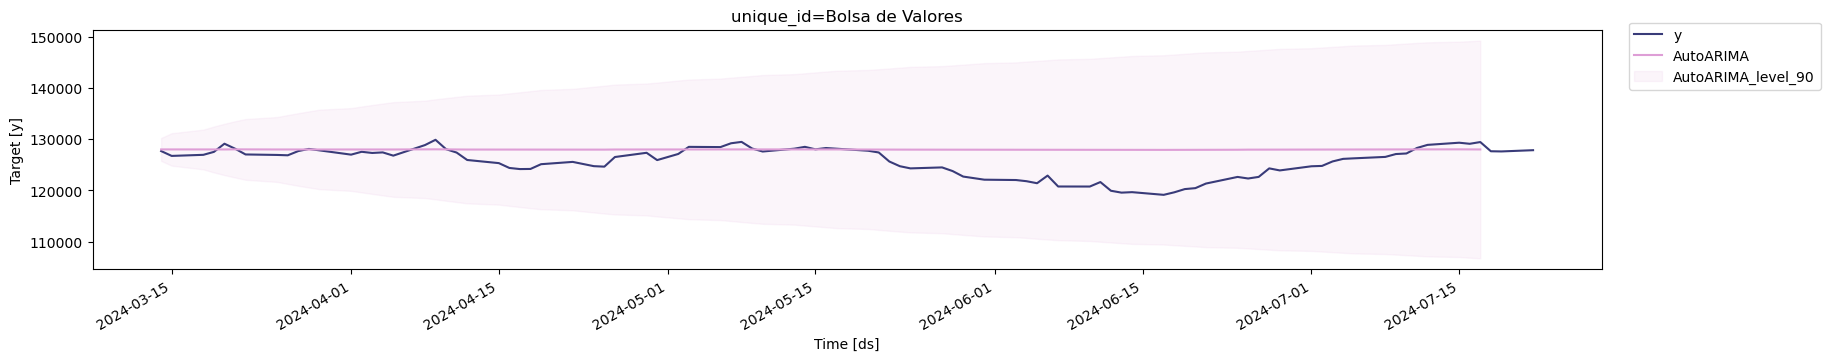

In [41]:
modelo_autoarima.plot(teste_autoarima, previsoes_autoarima, level = [90], unique_ids = ['Bolsa de Valores'], engine = 'matplotlib')

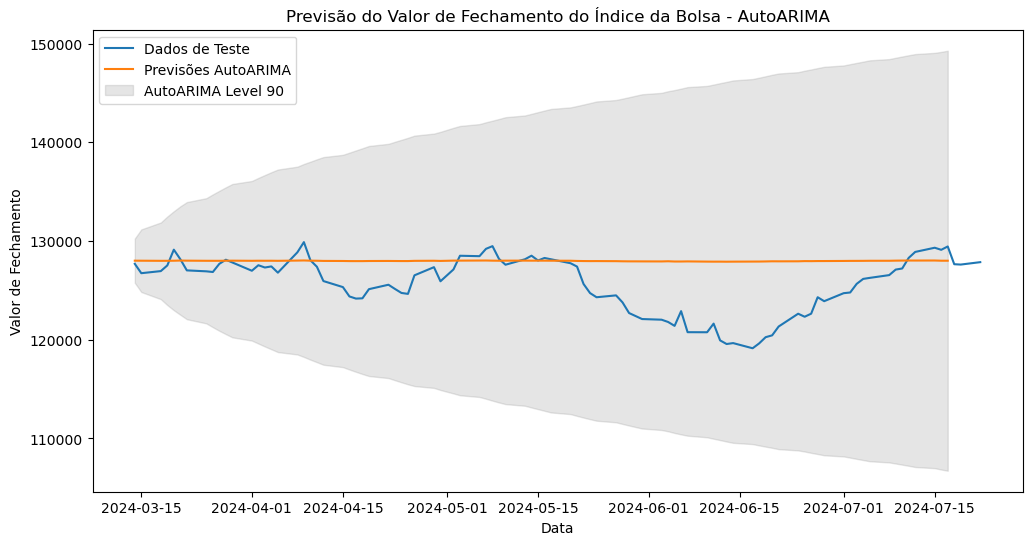

In [42]:
# Visualizando as previsões do modelo ARIMA
plt.figure(figsize=(12, 6))
plt.plot(teste_autoarima['ds'], teste_autoarima['y'], label='Dados de Teste')
plt.plot(previsoes_autoarima['ds'], previsoes_autoarima['AutoARIMA'], label='Previsões AutoARIMA')
plt.fill_between(previsoes_autoarima['ds'], previsoes_autoarima['AutoARIMA-lo-90'], previsoes_autoarima['AutoARIMA-hi-90'], color='gray', alpha=0.2, label='AutoARIMA Level 90')

plt.title('Previsão do Valor de Fechamento do Índice da Bolsa - AutoARIMA')
plt.xlabel('Data')
plt.ylabel('Valor de Fechamento')
plt.legend(loc='upper left')
plt.show()

In [43]:
metrics_autoarima = calculate_metrics(teste_autoarima['y'].values, previsoes_autoarima['AutoARIMA'].values)
print_metrics('AutoARIMA', metrics_autoarima)

AutoARIMA Metrics:
MAE: 2641.5803819444445
MSE: 13255012.986298285
MAPE: 2.1475364199446942


### Prophet

In [44]:
# Preparando dados de treino para o Prophet
train_prophet = treino.copy()
train_prophet = train_prophet.reset_index()
train_prophet = train_prophet.rename(columns={'data': 'ds', 'fechamento': 'y'})
train_prophet.head()

,ds,y,abertura
0,2021-07-22,126147,125930
1,2021-07-23,125053,126140
2,2021-07-26,126004,125058
3,2021-07-27,124612,126004
4,2021-07-28,126286,124615


In [45]:
# Preparando dados de teste para o Prophet
test_prophet = teste.copy()
test_prophet = test_prophet.reset_index()
test_prophet = test_prophet.rename(columns={'data': 'ds', 'fechamento': 'y'})
test_prophet

,ds,y,abertura
0,2024-03-14,127690,127992
1,2024-03-15,126742,127682
2,2024-03-18,126954,126758
3,2024-03-19,127529,126955
4,2024-03-20,129125,127534
...,...,...,...
85,2024-07-16,129110,129322
86,2024-07-17,129450,129112
87,2024-07-18,127652,129450
88,2024-07-19,127616,127652


In [73]:
model_prophet = Prophet(weekly_seasonality=False,
        yearly_seasonality=True,
        daily_seasonality=False)

model_prophet.add_country_holidays(country_name='BR')
model_prophet.add_regressor('abertura')

model_prophet.fit(train_prophet)

future_prophet= model_prophet.make_future_dataframe(periods=test_size, freq='B') # freq='B' (dias úteis - business days)
future_prophet['abertura'] = pd.concat([train_prophet['abertura'], test_prophet['abertura'], test_prophet['abertura']], ignore_index=True)

predict_prophet = model_prophet.predict(future_prophet)
predict_prophet.sort_values(by='ds')

23:18:14 - cmdstanpy - INFO - Chain [1] start processing
23:18:14 - cmdstanpy - INFO - Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Confraternização Universal,Confraternização Universal_lower,Confraternização Universal_upper,Dia Nacional de Zumbi e da Consciência Negra,...,holidays,holidays_lower,holidays_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-07-22,112970.011154,123683.757452,127087.310485,112970.011154,112970.011154,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,227.862773,227.862773,227.862773,0.0,0.0,0.0,125383.143512
1,2021-07-23,112970.097692,123910.492691,127322.489270,112970.097692,112970.097692,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,251.924293,251.924293,251.924293,0.0,0.0,0.0,125608.515182
2,2021-07-26,112970.357308,122943.449947,126140.625903,112970.357308,112970.357308,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,302.050554,302.050554,302.050554,0.0,0.0,0.0,124622.120358
3,2021-07-27,112970.443846,123929.601764,127287.294055,112970.443846,112970.443846,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,311.191377,311.191377,311.191377,0.0,0.0,0.0,125537.812176
4,2021-07-28,112970.530385,122536.531502,125993.984810,112970.530385,112970.530385,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,316.656368,316.656368,316.656368,0.0,0.0,0.0,124212.413251
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
744,2024-07-11,114348.990348,127976.597855,131267.753312,114306.555981,114395.687680,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-151.173015,-151.173015,-151.173015,0.0,0.0,0.0,129633.327338
745,2024-07-12,114351.751096,127875.291077,131211.282483,114308.569288,114399.186272,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-115.845353,-115.845353,-115.845353,0.0,0.0,0.0,129470.192137
746,2024-07-15,114360.033339,128191.084259,131649.869325,114315.713473,114408.406532,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-2.225875,-2.225875,-2.225875,0.0,0.0,0.0,129915.968051
747,2024-07-16,114362.794087,126608.201536,129938.791451,114317.880869,114412.178091,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,36.268917,36.268917,36.268917,0.0,0.0,0.0,128234.366199


In [47]:
model_prophet.train_holiday_names

0                      Confraternização Universal
1                               Sexta-feira Santa
2                                      Tiradentes
3                              Dia do Trabalhador
4                         Independência do Brasil
5                         Nossa Senhora Aparecida
6                                         Finados
7                        Proclamação da República
8    Dia Nacional de Zumbi e da Consciência Negra
9                                           Natal
dtype: object

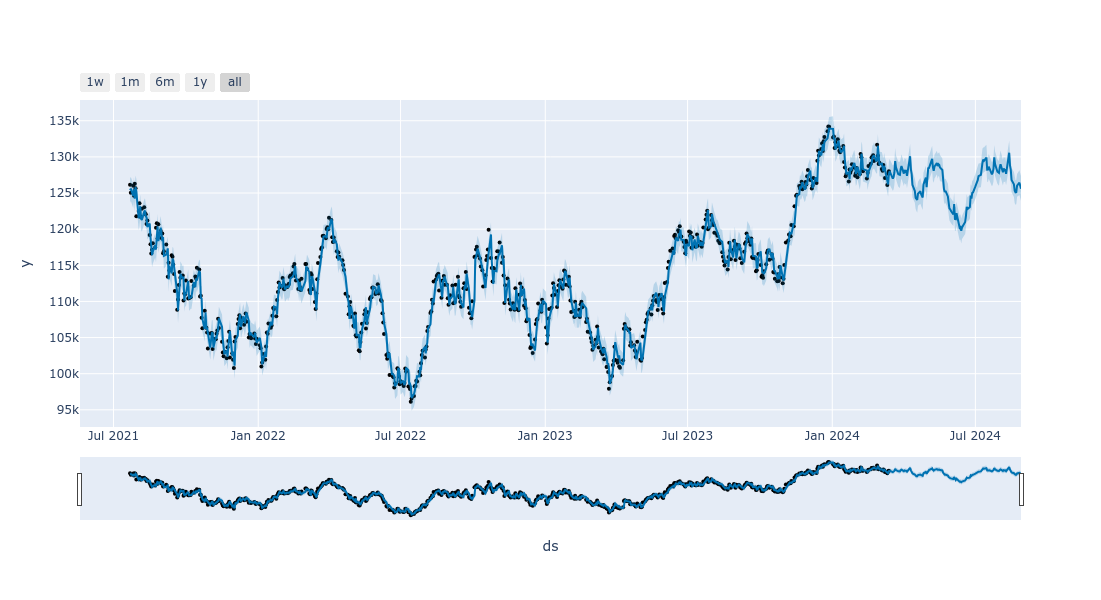

In [67]:
prophet_plot(model_prophet, predict_prophet)

In [72]:
predict_prophet = predict_prophet.tail(test_size)[['ds', 'yhat']].reset_index(drop=True)
predict_prophet.tail()

,ds,yhat
85,2024-08-22,125134.051376
86,2024-08-23,126020.781379
87,2024-08-26,126437.268252
88,2024-08-27,126024.420788
89,2024-08-28,125602.163174


In [53]:
metrics_prophet = calculate_metrics(test_prophet['y'].values[1:], test_prophet['y'].rolling(window=2).mean().dropna().values)
print_metrics('Rolling Mean', metrics_prophet)

Rolling Mean Metrics:
MAE: 340.55056179775283
MSE: 188142.04494382022
MAPE: 0.271009208063943


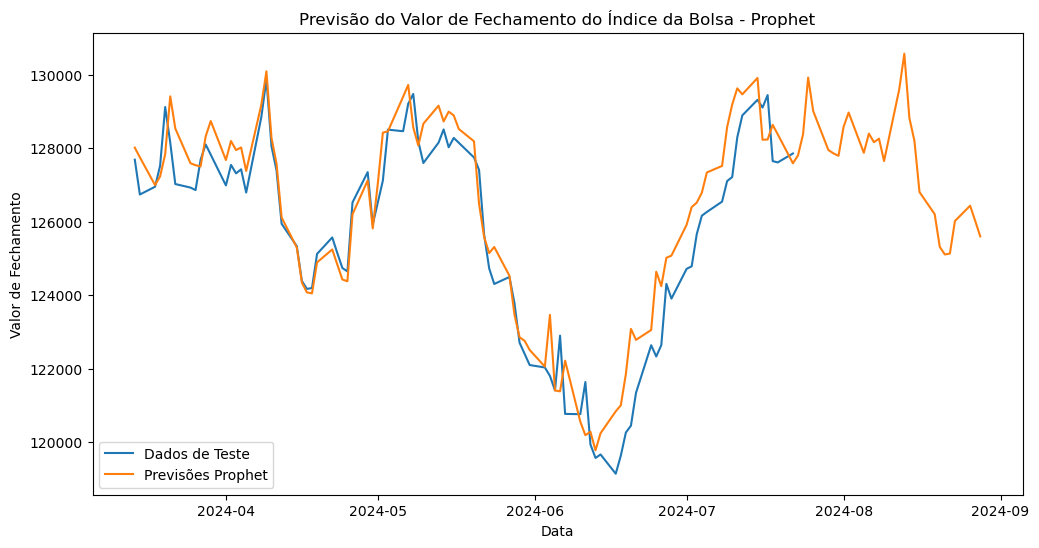

In [71]:
# Visualizando as previsões do modelo Prophet
plt.figure(figsize=(12, 6))
plt.plot(test_prophet['ds'], test_prophet['y'], label='Dados de Teste')
plt.plot(predict_prophet['ds'], predict_prophet['yhat'], label='Previsões Prophet')

plt.title('Previsão do Valor de Fechamento do Índice da Bolsa - Prophet')
plt.xlabel('Data')
plt.ylabel('Valor de Fechamento')
plt.legend(loc='best')
plt.show()

In [55]:
metrics_prophet = calculate_metrics(test_prophet['y'].values, predict_prophet['yhat'].values)
print_metrics('Prophet', metrics_prophet)

Prophet Metrics:
MAE: 815.4644360737677
MSE: 1066505.5586739862
MAPE: 0.6504004066948613


In [56]:
# Filtrar previsões para o período de treinamento e teste
forecast_train = predict_prophet[predict_prophet['ds'] < '2024-06-11']
forecast_train


,ds,yhat
0,2024-03-14,128018.726060
1,2024-03-15,127756.275161
2,2024-03-18,126998.459875
3,2024-03-19,127235.587050
4,2024-03-20,127840.338817
...,...,...
58,2024-06-04,123463.607433
59,2024-06-05,121405.289611
60,2024-06-06,121381.905227
61,2024-06-07,122216.598459


In [57]:
forecast_test = predict_prophet[predict_prophet['ds'] >= '2024-06-11']
forecast_test = forecast_test.reset_index(drop=True)
forecast_test

,ds,yhat
0,2024-06-11,120186.648134
1,2024-06-12,120282.326281
2,2024-06-13,119774.744914
3,2024-06-14,120241.734901
4,2024-06-17,120836.494395
5,2024-06-18,121001.436058
6,2024-06-19,121853.552163
7,2024-06-20,123082.416574
8,2024-06-21,122783.221668
9,2024-06-24,123052.742657


#### Testando Overfitting

In [58]:
# Supondo que você tenha previsões para treinamento e teste
mape_train = np.abs((train_prophet['y'] - forecast_train['yhat']) / train_prophet['y']).mean() * 100
mape_test = np.abs((test_prophet['y'] - forecast_test['yhat']) / test_prophet['y']).mean() * 100

print(f"MAPE nos Dados de Treinamento: {mape_train:.2f}%")
print(f"MAPE nos Dados de Teste: {mape_test:.2f}%")

MAPE nos Dados de Treinamento: 8.25%
MAPE nos Dados de Teste: 3.19%


O fato de o MAPE nos dados de teste ser menor do que nos dados de treinamento não é comum e não é um sinal típico de overfitting. Overfitting geralmente é indicado por um MAPE muito baixo em dados de treinamento e um MAPE significativamente maior em dados de teste. Nesse caso, o MAPE em dados de teste é menor, o que pode indicar que o modelo está generalizando bem e, possivelmente, foi ajustado de forma robusta.

### XGBoost

In [59]:
# Preparando dados de treino para o XGBoost
train_xgb = treino.copy()
train_xgb = train_xgb.reset_index()
train_xgb['ano'] = train_xgb['data'].dt.year
train_xgb['mes'] = train_xgb['data'].dt.month
train_xgb['dia'] = train_xgb['data'].dt.day
train_xgb['diadasemana'] = train_xgb['data'].dt.dayofweek
train_xgb.tail()

,data,fechamento,abertura,ano,mes,dia,diadasemana
654,2024-03-07,128340,128890,2024,3,7,3
655,2024-03-08,127071,128335,2024,3,8,4
656,2024-03-11,126124,127068,2024,3,11,0
657,2024-03-12,127668,126124,2024,3,12,1
658,2024-03-13,128006,127668,2024,3,13,2


In [60]:
# Preparando dados de treino para o XGBoost
test_xgb = teste.copy()
test_xgb = test_xgb.reset_index()
test_xgb['ano'] = test_xgb['data'].dt.year
test_xgb['mes'] = test_xgb['data'].dt.month
test_xgb['dia'] = test_xgb['data'].dt.day
test_xgb['diadasemana'] = test_xgb['data'].dt.dayofweek
test_xgb.tail()

,data,fechamento,abertura,ano,mes,dia,diadasemana
85,2024-07-16,129110,129322,2024,7,16,1
86,2024-07-17,129450,129112,2024,7,17,2
87,2024-07-18,127652,129450,2024,7,18,3
88,2024-07-19,127616,127652,2024,7,19,4
89,2024-07-22,127860,127616,2024,7,22,0


In [61]:
FEATURES = ['ano', 'mes', 'dia', 'diadasemana', 'abertura']
TARGET = 'fechamento'

X_train_xgb, y_train_xgb = train_xgb[FEATURES], train_xgb[TARGET]
X_test_xgb, y_test_xgb = test_xgb[FEATURES], test_xgb[TARGET]

reg = xgb.XGBRegressor(objective='reg:squarederror')
reg.fit(X_train_xgb, y_train_xgb)

# Avaliação XGBoost
predict_xgb = reg.predict(X_test_xgb)
predict_xgb

array([127766.73 , 128253.27 , 126699.47 , 127549.805, 128525.195,
       129034.66 , 127987.28 , 126689.47 , 127507.984, 127413.9  ,
       128045.695, 127574.1  , 127708.625, 129135.16 , 127680.63 ,
       128330.484, 126204.78 , 128827.93 , 129473.92 , 127068.69 ,
       127861.28 , 126109.125, 126185.97 , 123335.875, 122597.63 ,
       122328.4  , 125559.41 , 126234.734, 125842.53 , 124929.516,
       124403.54 , 126195.25 , 127529.695, 126325.42 , 127364.9  ,
       128247.984, 127994.76 , 128445.56 , 129093.05 , 127633.51 ,
       127746.164, 127925.875, 127766.69 , 127845.39 , 127553.01 ,
       127383.77 , 128236.3  , 128355.43 , 125522.5  , 124506.24 ,
       122895.766, 123220.33 , 121458.64 , 118138.   , 122871.125,
       122518.9  , 122006.234, 120838.51 , 121640.555, 120564.95 ,
       121028.17 , 122501.516, 119649.5  , 118514.05 , 119228.766,
       119564.6  , 119954.2  , 119834.02 , 120105.195, 120937.51 ,
       122255.66 , 122006.2  , 119979.62 , 121909.625, 122234.

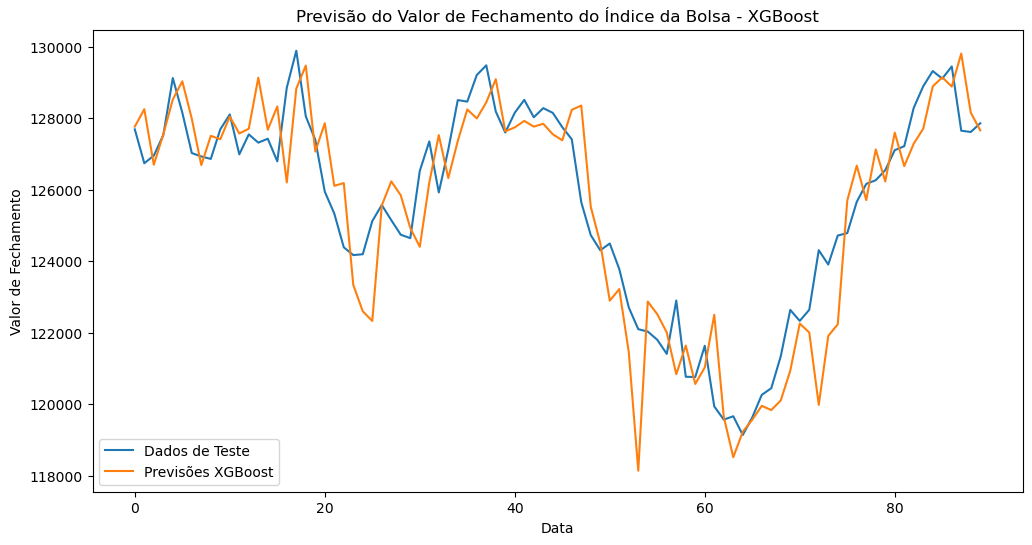

In [62]:
# Visualizando as previsões do modelo XGBoost
plt.figure(figsize=(12, 6))
plt.plot(X_test_xgb.index, y_test_xgb, label='Dados de Teste')
plt.plot(X_test_xgb.index, predict_xgb, label='Previsões XGBoost')

plt.title('Previsão do Valor de Fechamento do Índice da Bolsa - XGBoost')
plt.xlabel('Data')
plt.ylabel('Valor de Fechamento')
plt.legend(loc='best')
plt.show()

In [63]:
metrics_xgb = calculate_metrics(y_test_xgb, predict_xgb)
print_metrics('XGBoost', metrics_xgb)

XGBoost Metrics:
MAE: 958.3646701388889
MSE: 1629571.6242926703
MAPE: 0.7648225527191221


## Passo 3: Comparando os modelos

In [64]:
df_metrics = pd.DataFrame(
    [metrics_arima, metrics_autoarima, metrics_prophet, metrics_xgb],
    columns=['MAE', 'MSE', 'MAPE'],
    index=['ARIMA', 'AutoARIMA', 'Prophet', 'XGBoost'],
)
df_metrics

,MAE,MSE,MAPE
ARIMA,2671.241273,1.356012e+07,2.171682
AutoARIMA,2641.580382,1.325501e+07,2.147536
Prophet,815.464436,1.066506e+06,0.650400
XGBoost,958.364670,1.629572e+06,0.764823
